# Librerias a instalar

In [ ]:
!pip install -q -U git+https://github.com/huggingface/transformers.git # installing latest version of transformers library
!pip install torch # torch
!pip install peft # necessary for finetuning of the large model via LoRA approach
!pip install bitsandbytes # necessary for quantiziation
!pip install evaluate # extension of the transformers library
!pip install datasets # extension of the transformers library
!pip install accelerate
!pip install emoji

# Importar librerias

In [ ]:
import torch
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding)
import bitsandbytes as bnb
import evaluate
import numpy as np
import random
import re
import emoji
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import wordnet
from collections import Counter
# Descargar recursos de NLTK si es necesario
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')


In [ ]:
def limpiar_texto(texto):
    """
    Función para limpiar tweets en español
    """
    if pd.isna(texto):
        return ""

    # Convertir a string si no lo es
    texto = str(texto)

    # Eliminar menciones (@usuario)
    texto = re.sub(r'@\w+', '', texto)

    # Eliminar hashtags manteniendo el texto
    texto = re.sub(r'#(\w+)', r'\1', texto)

    # Eliminar URLs
    texto = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', texto)

    # Eliminar emojis
    texto = emoji.demojize(texto, delimiters=("", ""))
    texto = re.sub(r':[a-z_]+:', '', texto)

    # Eliminar caracteres especiales excesivos
    texto = re.sub(r'[^\w\s¿¡!?.,;:\-áéíóúüñÁÉÍÓÚÜÑ]', '', texto)

    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto)

    # Eliminar espacios al inicio y final
    texto = texto.strip()

    return texto

def obtener_sinonimos(palabra):
    """
    Obtiene sinónimos de una palabra usando WordNet
    """
    sinonimos = set()
    for syn in wordnet.synsets(palabra, lang='spa'):  # Español
        for lemma in syn.lemmas('spa'):
            sinonimo = lemma.name().replace('_', ' ')
            if sinonimo.lower() != palabra.lower():
                sinonimos.add(sinonimo)

    # Si no hay sinónimos en español, intenta en inglés
    if not sinonimos:
        for syn in wordnet.synsets(palabra):
            for lemma in syn.lemmas():
                sinonimo = lemma.name().replace('_', ' ')
                if sinonimo.lower() != palabra.lower():
                    sinonimos.add(sinonimo)

    return list(sinonimos)

def sustituir_sinonimos(texto, probabilidad=0.3):
    """
    Sustituye algunas palabras por sinónimos con cierta probabilidad
    """
    palabras = texto.split()
    nuevas_palabras = []

    for palabra in palabras:
        # Solo sustituir palabras largas y con cierta probabilidad
        if len(palabra) > 4 and random.random() < probabilidad:
            # Limpiar la palabra de signos de puntuación
            palabra_limpia = re.sub(r'[^\w]', '', palabra.lower())
            sinonimos = obtener_sinonimos(palabra_limpia)

            if sinonimos:
                # Mantener la capitalización original
                sinonimo = random.choice(sinonimos)
                if palabra[0].isupper():
                    sinonimo = sinonimo.capitalize()
                nuevas_palabras.append(sinonimo)
            else:
                nuevas_palabras.append(palabra)
        else:
            nuevas_palabras.append(palabra)

    return ' '.join(nuevas_palabras)

def aplicar_data_augmentation(df, clase_minoritaria, target_count):
    """
    Aplica data augmentation para balancear las clases
    """
    print(f"Aplicando data augmentation para clase {clase_minoritaria}...")

    # Filtrar ejemplos de la clase minoritaria
    df_minoritaria = df[df['label'] == clase_minoritaria].copy()
    ejemplos_actuales = len(df_minoritaria)
    ejemplos_necesarios = target_count - ejemplos_actuales

    print(f"Ejemplos actuales: {ejemplos_actuales}")
    print(f"Ejemplos necesarios: {ejemplos_necesarios}")

    if ejemplos_necesarios <= 0:
        return df

    # Generar nuevos ejemplos
    nuevos_ejemplos = []

    for i in range(ejemplos_necesarios):
        # Seleccionar un ejemplo aleatorio de la clase minoritaria
        ejemplo_original = df_minoritaria.sample(n=1).iloc[0]

        # Aplicar sustitución de sinónimos
        texto_aumentado = sustituir_sinonimos(ejemplo_original['text'])

        # Crear nuevo ejemplo
        nuevo_ejemplo = {
            'text': texto_aumentado,
            'label': clase_minoritaria
        }
        nuevos_ejemplos.append(nuevo_ejemplo)

        if (i + 1) % 100 == 0:
            print(f"Generados {i + 1}/{ejemplos_necesarios} ejemplos...")

    # Crear DataFrame con nuevos ejemplos
    df_aumentado = pd.DataFrame(nuevos_ejemplos)

    # Combinar con el dataset original
    df_final = pd.concat([df, df_aumentado], ignore_index=True)

    print(f"Dataset final: {len(df_final)} ejemplos")
    print(f"Nueva distribución: {df_final['label'].value_counts()}")

    return df_final

# CARGAR Y PROCESAR DATOS

In [ ]:
print("Cargando datos...")
df = pd.read_csv("/content/dataset_unido_final_sinURL.csv")

# Aplicar limpieza
x = df["Teaser Text"].apply(limpiar_texto)
y = df["Tag Value"]

print(f"Distribución original: {y.value_counts()}")

# Crear DataFrame inicial
df_procesado = pd.DataFrame({'text': x, 'label': y})

# PASO 1: CALCULAR CLASS WEIGHTS
print("\n=== CALCULANDO CLASS WEIGHTS ===")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

# PASO 2: APLICAR OVERSAMPLING
print("\n=== APLICANDO RANDOM OVERSAMPLING ===")
# Primero aplicamos oversampling para llevar la clase minoritaria a ~1500
ros = RandomOverSampler(sampling_strategy={0: 2499, 1: 1500}, random_state=42)
X_resampled, y_resampled = ros.fit_resample(
    df_procesado[['text']],
    df_procesado['label']
)

df_resampled = pd.DataFrame({
    'text': X_resampled['text'],
    'label': y_resampled
})

print(f"Después de oversampling: {df_resampled['label'].value_counts()}")

# PASO 3: APLICAR DATA AUGMENTATION CON SINÓNIMOS
print("\n=== APLICANDO DATA AUGMENTATION ===")
df_final = aplicar_data_augmentation(df_resampled, clase_minoritaria=1, target_count=2100)

print(f"\nDistribución final: {df_final['label'].value_counts()}")

# DIVISIÓN ESTRATIFICADA
print("\n=== DIVISIÓN DEL DATASET ===")
X_train, X_test, y_train, y_test = train_test_split(
    df_final['text'],
    df_final['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_final['label']
)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

print(f"Train: {train_df['label'].value_counts()}")
print(f"Test: {test_df['label'].value_counts()}")

# Convertir a Dataset de HuggingFace
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(test_df)

# CONFIGURAR MODELO Y TOKENIZER

In [ ]:
model_id = "meta-llama/Llama-3.2-3B"

print("Configurando tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Vocab size del modelo {model_id}: {len(tokenizer.get_vocab())}")

# FUNCIÓN DE PREPROCESAMIENTO
def preprocess_function(examples):
    return tokenizer(examples["text"],
                    truncation=True,
                    padding=True,
                    max_length=512)

# TOKENIZAR DATASETS
print("Tokenizando datasets...")
train_token = train_dataset.map(preprocess_function, batched=True)
test_token = eval_dataset.map(preprocess_function, batched=True)

# CONFIGURAR ETIQUETAS
id2label = {0: "No", 1: "Clickbait"}
label2id = {"No": 0, "Clickbait": 1}

# DATA COLLATOR
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# MÉTRICAS PERSONALIZADAS PARA DATASETS DESBALANCEADOS
metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calcular métricas estándar
    results = metric.compute(predictions=predictions, references=labels)

    # Agregar F1 para cada clase
    from sklearn.metrics import f1_score, precision_recall_fscore_support

    # F1 macro (promedio de F1 de cada clase)
    f1_macro = f1_score(labels, predictions, average='macro')

    # F1 por clase
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )

    results.update({
        'f1_macro': f1_macro,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1],
        'precision_class_0': precision[0],
        'precision_class_1': precision[1],
        'recall_class_0': recall[0],
        'recall_class_1': recall[1]
    })

    return results

# CONFIGURACIÓN DE QUANTIZACIÓN
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# CARGAR MODELO
print("Cargando modelo...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    quantization_config=bnb_config,
    device_map={"": 0},
    pad_token_id=tokenizer.pad_token_id
)

# CONFIGURAR MODELO PARA ENTRENAMIENTO
print("Configurando modelo para entrenamiento...")
model.config.pad_token_id = tokenizer.pad_token_id
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# CONFIGURAR LORA
def find_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()

    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')

    return list(lora_module_names)

modules = find_linear_names(model)
print(f"Módulos LoRA: {modules}")

lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=modules,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# TRAINER PERSONALIZADO CON CLASS WEIGHTS
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Aplicar class weights
        if labels is not None:
            # Crear tensor de pesos para cada ejemplo basado en su etiqueta
            weights = torch.tensor([class_weight_dict[label.item()] for label in labels]).to(labels.device)

            # Usar CrossEntropyLoss con peso por ejemplo
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

            # Aplicar pesos y promediar
            weighted_loss = (loss * weights).mean()
        else:
            weighted_loss = outputs.get("loss")

        return (weighted_loss, outputs) if return_outputs else weighted_loss

# ARGUMENTOS DE ENTRENAMIENTO MEJORADOS
training_args = TrainingArguments(
    output_dir="epoch_weights_balanced",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=8,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    metric_for_best_model='eval_f1_macro',
    greater_is_better=True,
    logging_steps=50,
    warmup_steps=100,
    fp16=True,
    dataloader_num_workers=2,
    group_by_length=True
)

# EARLY STOPPING CON MAS PACIENCIA
early_stop = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.001
)

# CREAR TRAINER
print("Creando trainer...")
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_token,
    eval_dataset=test_token,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

# ENTRENAR
print("Iniciando entrenamiento...")
print(f"Total de pasos de entrenamiento: {len(train_token) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

# Guardar informacion del dataset
dataset_info = {
    'original_distribution': dict(df['Tag Value'].value_counts()),
    'final_distribution': dict(df_final['label'].value_counts()),
    'class_weights': class_weight_dict,
    'train_size': len(train_df),
    'test_size': len(test_df)
}

print("\n=== INFORMACION DEL DATASET ===")
for key, value in dataset_info.items():
    print(f"{key}: {value}")


trainer.train()
print("Entrenamiento completado exitosamente!")



Cargando datos...
Distribución original: Tag Value
0    2499
1    1001
Name: count, dtype: int64

=== CALCULANDO CLASS WEIGHTS ===
Class weights: {0: np.float64(0.7002801120448179), 1: np.float64(1.7482517482517483)}

=== APLICANDO RANDOM OVERSAMPLING ===
Después de oversampling: label
0    2499
1    1500
Name: count, dtype: int64

=== APLICANDO DATA AUGMENTATION ===
Aplicando data augmentation para clase 1...
Ejemplos actuales: 1500
Ejemplos necesarios: 600
Generados 100/600 ejemplos...
Generados 200/600 ejemplos...
Generados 300/600 ejemplos...
Generados 400/600 ejemplos...
Generados 500/600 ejemplos...
Generados 600/600 ejemplos...
Dataset final: 4599 ejemplos
Nueva distribución: label
0    2499
1    2100
Name: count, dtype: int64

Distribución final: label
0    2499
1    2100
Name: count, dtype: int64

=== DIVISIÓN DEL DATASET ===
Train: label
0    1999
1    1680
Name: count, dtype: int64
Test: label
0    500
1    420
Name: count, dtype: int64
Configurando tokenizer...
Vocab size d

Map:   0%|          | 0/3679 [00:00<?, ? examples/s]

Map:   0%|          | 0/920 [00:00<?, ? examples/s]

Cargando modelo...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configurando modelo para entrenamiento...
Módulos LoRA: ['gate_proj', 'q_proj', 'k_proj', 'o_proj', 'v_proj', 'up_proj', 'down_proj']


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 97,261,568 || all params: 3,310,017,536 || trainable%: 2.9384
Creando trainer...
Iniciando entrenamiento...
Total de pasos de entrenamiento: 7352

=== INFORMACION DEL DATASET ===
original_distribution: {0: np.int64(2499), 1: np.int64(1001)}
final_distribution: {0: np.int64(2499), 1: np.int64(2100)}
class_weights: {0: np.float64(0.7002801120448179), 1: np.float64(1.7482517482517483)}
train_size: 3679
test_size: 920


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Macro,F1 Class 0,F1 Class 1,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1
1,0.341900,0.392726,0.888043,0.882286,0.848352,0.919048,0.887775,0.893264,0.882286,0.926882,0.848352,0.862000,0.919048
2,0.346200,0.308347,0.928261,0.920290,0.933824,0.907143,0.927536,0.934783,0.920290,0.923828,0.933824,0.946000,0.907143
3,0.094400,0.309100,0.933696,0.929804,0.899777,0.961905,0.933491,0.937178,0.929804,0.966030,0.899777,0.910000,0.961905
4,0.010500,0.323472,0.944565,0.940351,0.924138,0.957143,0.944287,0.948223,0.940351,0.962887,0.924138,0.934000,0.957143
5,0.021400,0.376201,0.954348,0.950355,0.943662,0.957143,0.954051,0.957746,0.950355,0.963563,0.943662,0.952000,0.957143
6,0.000400,0.362376,0.951087,0.947368,0.931034,0.964286,0.950842,0.954315,0.947368,0.969072,0.931034,0.940000,0.964286
7,0.000000,0.372603,0.946739,0.942957,0.922551,0.964286,0.946504,0.950051,0.942957,0.968815,0.922551,0.932000,0.964286


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

Entrenamiento completado exitosamente!


# Evaluación

=== EVALUACIÓN FINAL DEL MODELO ===
Usando el dataset de TEST separado durante el entrenamiento (NO usado para entrenar)
Dataset de test (separado del entrenamiento): 920 ejemplos
✅ Usando dataset de test del entrenamiento (datos no vistos por el modelo)
Realizando predicciones finales con el dataset de test...


✅ Predicciones realizadas en 920 ejemplos
Dataset usado: test_token (20% separado del entrenamiento original)

=== MÉTRICAS FINALES (DATOS NO VISTOS) ===
accuracy: 0.9543
f1: 0.9504
precision: 0.9437
recall: 0.9571
f1_macro: 0.9541
f1_class_0: 0.9577
f1_class_1: 0.9504
precision_class_0: 0.9636
precision_class_1: 0.9437
recall_class_0: 0.9520
recall_class_1: 0.9571


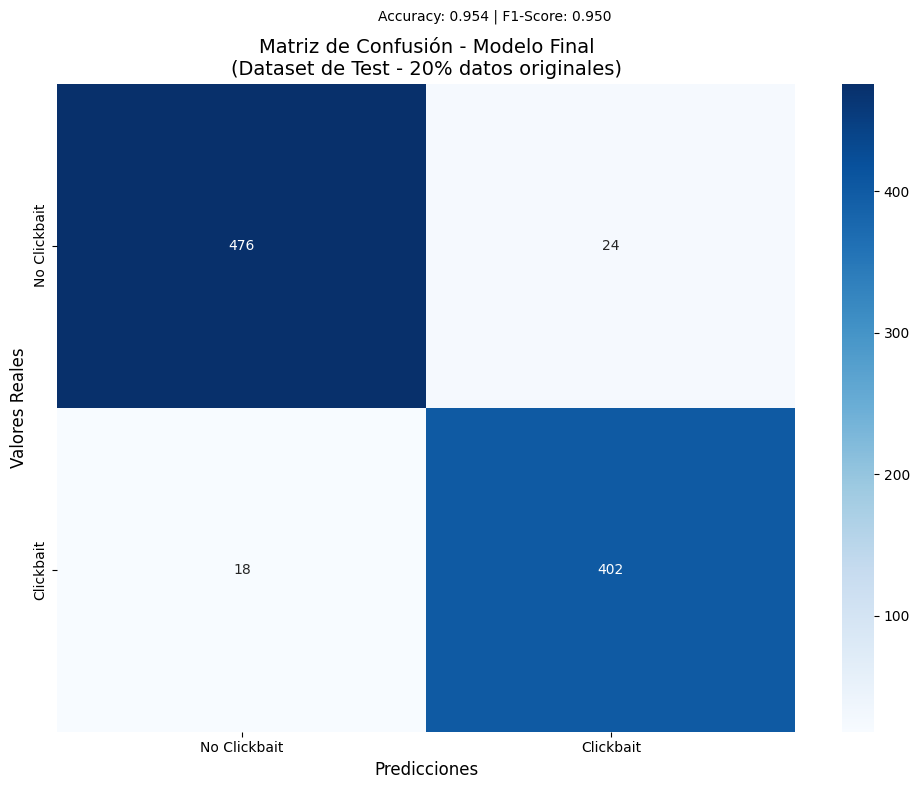


=== REPORTE DETALLADO POR CLASE ===
              precision    recall  f1-score   support

No Clickbait       0.96      0.95      0.96       500
   Clickbait       0.94      0.96      0.95       420

    accuracy                           0.95       920
   macro avg       0.95      0.95      0.95       920
weighted avg       0.95      0.95      0.95       920


=== MÉTRICAS DETALLADAS POR CLASE ===
No Clickbait:
  Precisión: 0.9636
  Recall: 0.9520
  F1-Score: 0.9577
  Soporte: 500

Clickbait:
  Precisión: 0.9437
  Recall: 0.9571
  F1-Score: 0.9504
  Soporte: 420

=== ANÁLISIS DE DISTRIBUCIÓN ===
Distribución real: [500 420]
Distribución predicha: [494 426]
% Real Clickbait: 45.7%
% Predicho Clickbait: 46.3%


In [ ]:
# =====================================================
# PARTE 1: EVALUACIÓN FINAL CON MATRIZ DE CONFUSIÓN
# =====================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import pandas as pd

print("=== EVALUACIÓN FINAL DEL MODELO ===")
print("Usando el dataset de TEST separado durante el entrenamiento (NO usado para entrenar)")

# 1. USAR EL DATASET DE TEST QUE YA ESTÁ EN MEMORIA DEL ENTRENAMIENTO
# Este dataset NO fue usado para entrenar, por lo tanto es una evaluación válida

print(f"Dataset de test (separado del entrenamiento): {len(test_token)} ejemplos")

# Verificar que las variables del entrenamiento estén disponibles
if 'test_token' not in locals():
    print("⚠️ ERROR: No se encuentra test_token del entrenamiento")
    print("Asegúrate de ejecutar este código después del entrenamiento")
else:
    print("✅ Usando dataset de test del entrenamiento (datos no vistos por el modelo)")

# 2. Hacer predicciones con el modelo final EN MEMORIA
print("Realizando predicciones finales con el dataset de test...")
try:
    # Usar el trainer Y el dataset de test que ya están en memoria del entrenamiento
    predictions_final = trainer.predict(test_token)  # test_token es el dataset NO usado para entrenar
    predicted_labels_final = np.argmax(predictions_final.predictions, axis=1)
    true_labels_final = predictions_final.label_ids

    print(f"✅ Predicciones realizadas en {len(predicted_labels_final)} ejemplos")
    print(f"Dataset usado: test_token (20% separado del entrenamiento original)")

    # 3. Calcular métricas finales
    final_metrics = trainer.compute_metrics((predictions_final.predictions, true_labels_final))

    print("\n=== MÉTRICAS FINALES (DATOS NO VISTOS) ===")
    for key, value in final_metrics.items():
        print(f"{key}: {value:.4f}")

    # 4. Matriz de confusión
    cm_final = confusion_matrix(true_labels_final, predicted_labels_final)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Clickbait", "Clickbait"],
                yticklabels=["No Clickbait", "Clickbait"])
    plt.title('Matriz de Confusión - Modelo Final\n(Dataset de Test - 20% datos originales)', fontsize=14)
    plt.xlabel('Predicciones', fontsize=12)
    plt.ylabel('Valores Reales', fontsize=12)

    # Agregar estadísticas en el título
    accuracy_final = (predicted_labels_final == true_labels_final).mean()
    f1_final = f1_score(true_labels_final, predicted_labels_final)
    plt.suptitle(f'Accuracy: {accuracy_final:.3f} | F1-Score: {f1_final:.3f}', fontsize=10)

    plt.tight_layout()
    plt.show()

    # 5. Reporte detallado por clase
    print("\n=== REPORTE DETALLADO POR CLASE ===")
    class_names = ["No Clickbait", "Clickbait"]
    print(classification_report(true_labels_final, predicted_labels_final, target_names=class_names))

    # 6. Métricas por clase
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        true_labels_final, predicted_labels_final, average=None, labels=[0, 1]
    )

    print("\n=== MÉTRICAS DETALLADAS POR CLASE ===")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precisión: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1_per_class[i]:.4f}")
        print(f"  Soporte: {support[i]}")
        print()

    # 7. Análisis de la distribución de predicciones
    print("=== ANÁLISIS DE DISTRIBUCIÓN ===")
    print(f"Distribución real: {np.bincount(true_labels_final)}")
    print(f"Distribución predicha: {np.bincount(predicted_labels_final)}")

    # Calcular métricas de balance
    true_clickbait_pct = (true_labels_final == 1).mean() * 100
    pred_clickbait_pct = (predicted_labels_final == 1).mean() * 100
    print(f"% Real Clickbait: {true_clickbait_pct:.1f}%")
    print(f"% Predicho Clickbait: {pred_clickbait_pct:.1f}%")

except Exception as e:
    print(f"❌ Error en evaluación: {e}")
    print("Verifica que el entrenamiento se haya completado correctamente")

print("=" * 60)


In [ ]:
trainer.save_model("./modelo_final_balanceado")